# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
n_records = data.shape[0]
n_greater_50k = np.sum(data.income == '>50K')
n_at_most_50k = np.sum(data.income == '<=50K')
# Express as a percent instead of a probability for some mysterious reason...
greater_percent = np.mean(data.income == '>50K') * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

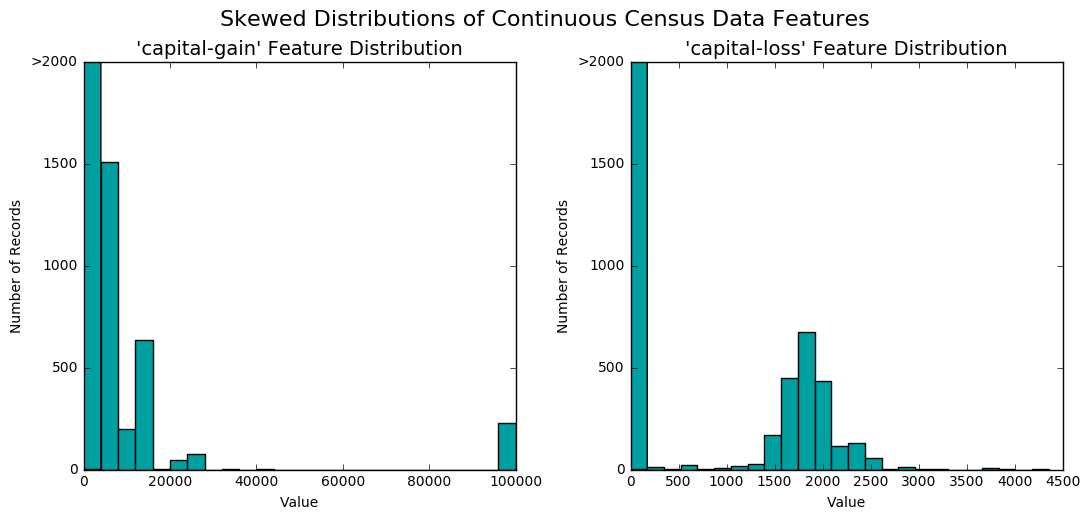

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

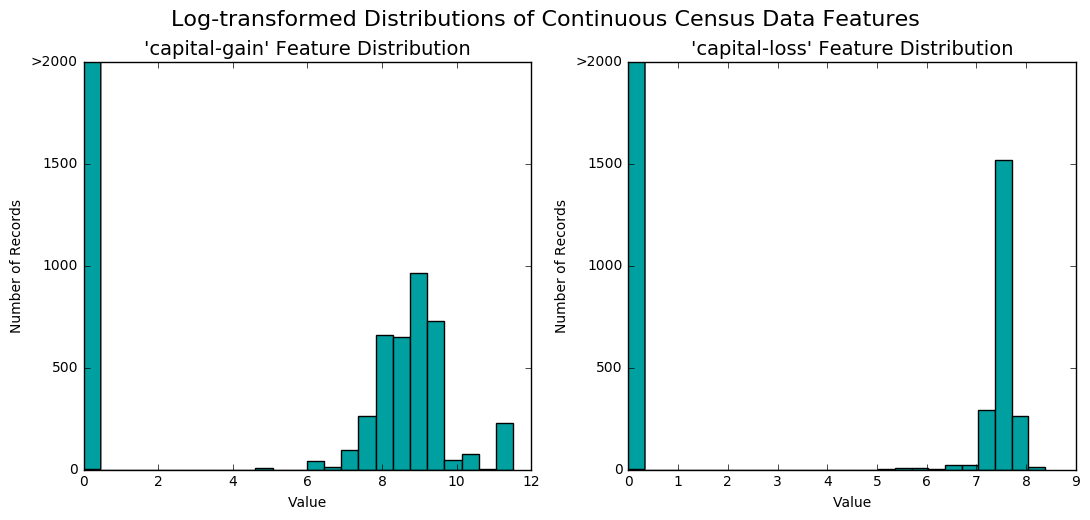

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# The default one-hot encoding method used by get_dummies will result in
# a design matrix of less than full rank, but the sklearn implementation
# of classical techniques (like logistic regression) doesn't seem to
# flinch at this.
features = pd.get_dummies(features_raw)
income = [int(x == '>50K') for x in income_raw]

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
accuracy = 1.0 * n_greater_50k / n_records
recall = 1.0

# Create a function that returns F-score from precision and recall for later use
def f_score_summary(precision, recall, beta=0.5):
    return (1 + beta ** 2) * (precision * recall) / ((beta ** 2 * precision) + recall)

# In general, accuracy != precision, but it works out this way for the naive predictor
fscore = f_score_summary(accuracy, recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


The naive model predicting true for every observation would have an accuracy of 0.2478 and an F-score of 0.2917.

###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

The first model I'll consider is a gradient boosted model. GBMs (and in particular, the XGBoost implementation of GBMs) have been the dominant ensemble classifiers for the past couple of years in terms of predictive performance, and are well-known for having excellent performance, even with minimal metaparameter tuning. However, GBMs are not  efficient (in the statistical sense) when the true model has a known parametric form, they can take a while to train, and although it is possible to estimate the marginal effects of individual predictors, these estimates are not smooth functions for continuous predictors, even when the underlying relationship is smooth. GBMs are widely used in industry -- for example, [this list of competition-winning applications of GBMs](https://github.com/dmlc/xgboost/blob/master/demo/README.md). Given the wide array of problems to which GBMs have been successfully applied, their performance on this data is likely to be good as well.

There are both theoretical and practical grounds on which to prefer GBMs over the other available ensemble methods. From a theoretical perspective, the other ensemble models have deficiencies compared to GBMs. It's been well-known for more than a decade that AdaBoost is a special case of a GBM with a bizarre choice of loss function that puts far too much weight on outliers. Random forests tend to result in less parsimonious models than GBMs, and bagging is just random forests without predictor sampling, so the resulting trees are too highly correlated. From a practical perspective, GBMs (and in particular, the XGBoost implementation of GBMs) consistently outperform other ensemble classifiers.

The second model I'll consider is logistic regression. Logistic regression has been around for decades, and is a popular form of linear classifier. Its statistical properties are well-understood, it gives good performance even the data are noisy or the classes are poorly separated, and it provides a vector of interpretable coefficients. However, logistic regression falls flat when the optimum decision boundary is not linear or nearly linear. In practice, much of the art of getting adequate performance out of a logistic regression model is in hand-selecting interactions and feature transformations to include to linearize the decision boundary. In this data set, there is good reason to expect that the relationship between income and each of the features is monotonic, regardless of the values of the other features. This implies that assuming a fairly linear decision boundary may not be too great a leap of faith. Logistic regression has been used in research and industry for decades in applications such as [credit scoring](http://www.repository.up.ac.za/dspace/bitstream/handle/2263/27333/dissertation.pdf?sequence=1).

There are a couple of advantages to logistic regression when compared to linear discriminant analysis, support vector machines, and stochastic gradient descent classifiers, despite the fact that all of these models have precisely the same expressive power. First, logistic regression is the maximum-likelihood solution to a reasonable statistical model of the data, instead of just trying to find some "best" separating hyperplane. Second, logistic regression can output probabilities as well as predicted classes, so it provides a measure of confidence in its own predictions on a natural and useful scale.

The final model I'll consider is k-nearest neighbors. K nearest neighbors has essentially zero training time and makes no assumptions about the structure of the model except for local smoothness. Despite this lack of assumption and simplistic algorithm, it has reasonably good performance with a good choice of k and a properly defined distance metric. However, k-nearest neighbors can be outperformed by more sophisticated models, and scoring large amounts of data can take a very, very long time.

Use of k-nearest neighbors in practical applications is a less common than the other two methods, but not completely un-heard of. For example, KNN has been applied to [breast cancer diagnosis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2243774/).

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# All of the classifiers we'll consider can return predicted
# probabilities, not just a simple yes or no. Scikit-learn's default
# behavior when predicting labels from classifiers is to return the
# most likely outcome -- in other words, 1 if p > 0.5.

# Thus implies that we can view each classifier as a family of labelers
# indexed by some parameter c, where the labeler returns 1 if p > c.
# There is no reason to think that the implicit default of c=0.5 is the
# labeler that will perform best on the F-score, particularly if we set
# beta to penalize false positives more than false negatives. Rather,
# we would naturally expect c to be larger tahn 0.5.

# The function below should be applied to predicted probabilities on
# test data, since for some of the classifiers we'll be applying this
# to, the distribution of predicted probabilities on the training data
# may be biased. The function does not depend on test *labels*, so 
# this isn't "cheating" from a machine learning perspective.
def find_best_cutoff(probs, beta=0.5):
    '''
    Find the cutoff value (c) that is predicted to maximize the F-score
    on test data for a given value of beta. 
    inputs:
        - probs: array of predicted probabilities for the target class
        - beta: value of beta for which to maximize the F-score
    returns: estimated cutoff probability that maximizes the F-score
    '''
    probs = sorted(probs, reverse=True)
    
    # We're effectively tracing the ROC curve to find the point that minimizes our
    # cost function.
    total_prob = np.sum(probs)
    cumulative_probs = np.cumsum(probs)
    cumulative_count = range(1, len(probs) + 1)
    
    precision = [p / c for p, c in zip(cumulative_probs, cumulative_count)]
    recall = [p / total_prob for p in cumulative_probs]
    f_scores = [f_score_summary(p, r, beta) for p, r in zip(precision, recall)]
    best_index = f_scores.index(max(f_scores))
    
    return probs[best_index]

# Create a prediction function for use with the train_predict pipeline
def predict_adjusted(learner, new_X, cutoff=None, beta=0.5):
    '''
    inputs:
        - learner: a classifier from scikit-learn
        - new_X: a 2-d array of input features to classify
        - cutoff: if supplied, the cutoff value for predictions. If not
            supplied, it will be estimated by find_best_cutoff.
        - beta: value of beta supplied to find_best_cutoff.
    returns: tuple of predicted labels and the cutoff value used
    '''
    probs = learner.predict_proba(new_X)[:, 1]
    if not cutoff:
        cutoff = find_best_cutoff(probs, beta)
    predictions = [int(p >= cutoff) for p in probs]
    return predictions, cutoff

# Define a scoring function for later use with make_scorer
def f_score_prob(y, y_prob, beta=0.5):
    '''
    inputs:
        - y: true labels for a data set
        - y_pred: predicted probabilities of (y == 1)
        - beta: beta of the F-score
    returns: F-score value
    '''
    y_prob = y_prob[:, 1]
    cutoff = find_best_cutoff(y_prob, beta)
    y_pred = [int(p >= cutoff) for p in y_prob]
    return fbeta_score(y, y_pred, beta)


In [10]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    TRAINING_HEAD_SIZE = 300
    
    # Fit the learner
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    results['train_time'] = end - start
        
    # Get predictions on test set and subset of training set
    start = time() # Get start time
    predictions_test, cutoff = predict_adjusted(learner, X_test, beta=0.5)
    predictions_train, cutoff = predict_adjusted(
        learner, X_train[:TRAINING_HEAD_SIZE], cutoff
    )
    end = time() # Get end time
    results['pred_time'] = end - start

    # Compute model evaluation metrics
    results['acc_train'] = accuracy_score(y_train[:TRAINING_HEAD_SIZE], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train[:TRAINING_HEAD_SIZE], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Announce success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


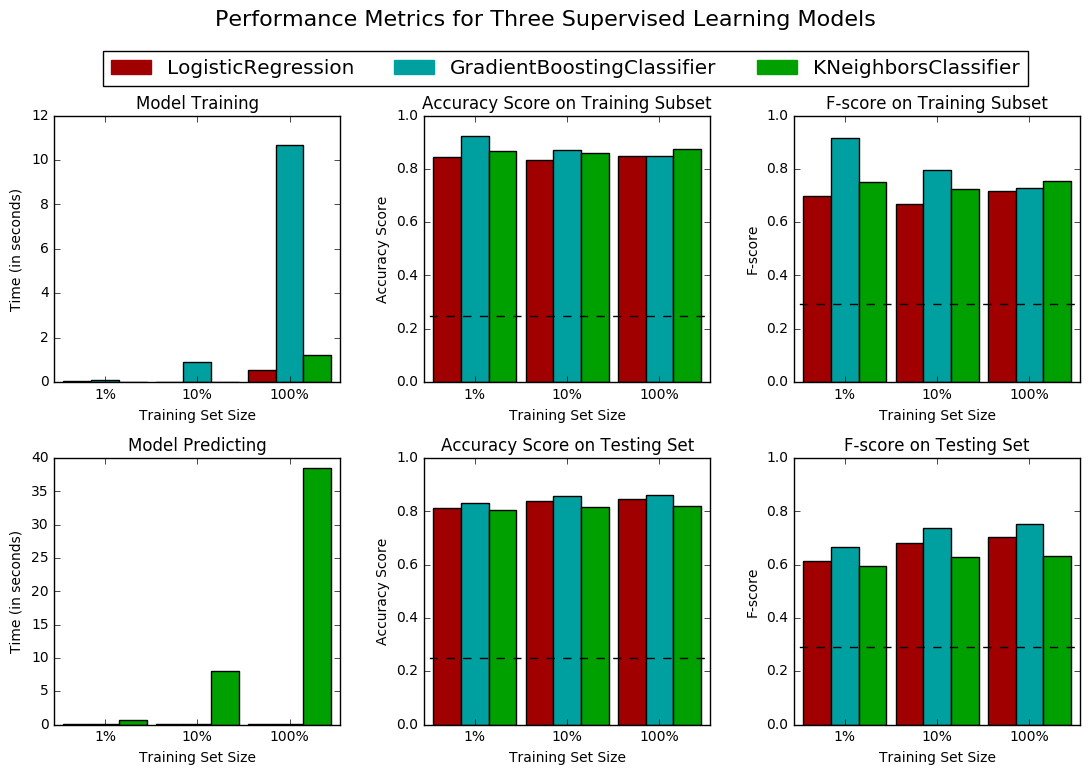

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

clf_A = GradientBoostingClassifier(random_state=1729)
clf_B = LogisticRegression()
clf_C = KNeighborsClassifier()

# Calculate the number of samples for different fractions of the
# training data.
n_train_records = X_train.shape[0]
samples_1 = n_train_records // 100
samples_10 = n_train_records // 10
samples_100 = n_train_records

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

The best class of models for this application is gradient boosted models. GBMs do take the longest amount of time to train, but it's a non-recurring, up-front cost, and the training time is still within the realm of reason. By contrast, GBM scoring is very quick, which means this model can handle a lot of throughput in production. Regardless of which metric you prefer (accuracy or F-score) or how much training data is available, GBMs are the best-performing class of model on out-of-sample data by a large margin.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

Gradient-boosted models are based on a type of classifier known as a decision tree. A decision tree turns the problem of deciding what class an object is in into a series of simple yes or no questions. The questions the decision tree "asks" can depend on the answers to previous questions, and at the end, the decision tree provides the most likely class the object belongs to, bsaed on the answers to each of the questions.

A gradient-boosted model improves on simple decision trees by forming an "ensemble" of trees. The model fits a decision tree to the data, adjusts the data to put more emphasis on objects that were incorrectly classified by the tree, then fits another decision tree to the adjusted data. This process of adjusting the data and fitting new trees proceeds until some large number of trees (say, 100 or 1000) have been trained. The model is then able to predict from new data by scoring the data through each of the trees, then letting all of the trees vote on the best class.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

clf = GradientBoostingClassifier(n_estimators=100, random_state=1729)

parameters = {'max_depth': [3, 7],
              'min_samples_leaf': [2, 10, 50],
              'subsample': [0.5, 1.0]}

scorer = make_scorer(f_score_prob, needs_proba=True)
grid_obj = GridSearchCV(clf, parameters, scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_

base_clf = clf.fit(X_train, y_train)
# Predictions from unoptimized GBM with cutoff = 0.5
base_predictions = base_clf.predict(X_test)
# Predictions from unoptimized GBM with adjusted cutoff
adj_predictions, cutoff = predict_adjusted(base_clf, X_test)
# Predictions from optimized GBM with adjusted cutoff
best_predictions, cutoff = predict_adjusted(best_clf, X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, base_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, base_predictions, beta = 0.5))
print "\nAdjusted model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, adj_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, adj_predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Adjusted model
------
Accuracy score on testing data: 0.8615
F-score on testing data: 0.7512

Optimized Model
------
Final accuracy score on the testing data: 0.8687
Final F-score on the testing data: 0.7684


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Adjusted Base Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-----------------: | :-------------: | 
| Accuracy Score | 0.2478              | 0.8630            |  0.8615             | 0.8687          |
| F-score        | 0.2917              | 0.7395            |  0.7512             | 0.7684          |


**Answer: **

The optimized model performs significantly better than the completely unoptimized model on the F-score (with a gain of almost 0.03), and slightly better on accuracy. It's no surprise that our optimized model performed better than our unoptimized model. Although GBMs have good performance over a very broad range of parameter settings, the choice of parameters can have a meaningful impact on model performance at the margins, and the default settings in scikit-learn's implementation of GBMs aren't particularly good.

It's interesting to note that almost half of the improvement in F-score from the completely unoptimized model to the optimized model can be had simply by adjusting the labeling cutoff probability to optimize the F-score. It's also worth noting that when comparing the unoptimized and adjusted base models, the adjusted base model has slightly worse accuracy. This is because both of these models are derived from the same set of predicted probabilities, and the default cutoff of 0.5 is always the optimal choice for optimizing accuracy. Thus, when we optimize the F-score, it is at the expense of accuracy to some extent.

All of the GBMs, optimized or not, are a vast improvement over the benchmark predictor. This is reassuring, because it means that the features we're trying to use to predict our labels have value as predictors. If our features were completely uncorrleated with our labels, the best we could hope for would be a slight improvement over the benchmark predictor due to random chance.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

Without exmaning the data and based purely on (admittedly limited) domain knowledge, I would guess the follow five attributes to be the most important in predicting income:

1. **Capital Gain:** Generally, lower-income individuals don't invest much in capital markets, so they are less likely to have significant capital gains. Furthermore, the amount of capital gains is likely proportional to the amount invested, which in turn is positively correlated with income.
2. **Capital Loss:** The line of reasoning here is similar to that for capital gains. In order to lose money in capital markets, you have to have invested money there in the first place, which is generally correlated with higher income.
3. **Age:** Ideally, it'd be nice to know the number of years' experience each person has in the industry they're currently employed in, but in the absence of such data, age should be fairly well-correlated with this unobserved feature.
4. **Occupation:** Some occupations (such as finance and healthcare) tend to be better-compensated than others (retail sales, childcare, etc.)
5. **Education-num:** Generally speaking, higher education should be correlated with higher salaries, but there are many exceptions. A social worker with a master's degree may make much less than a car salesman with a high school diploma.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

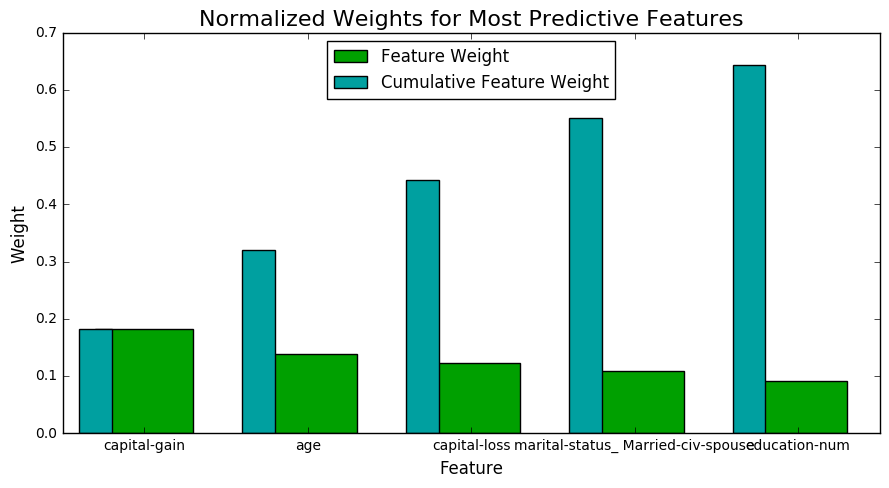

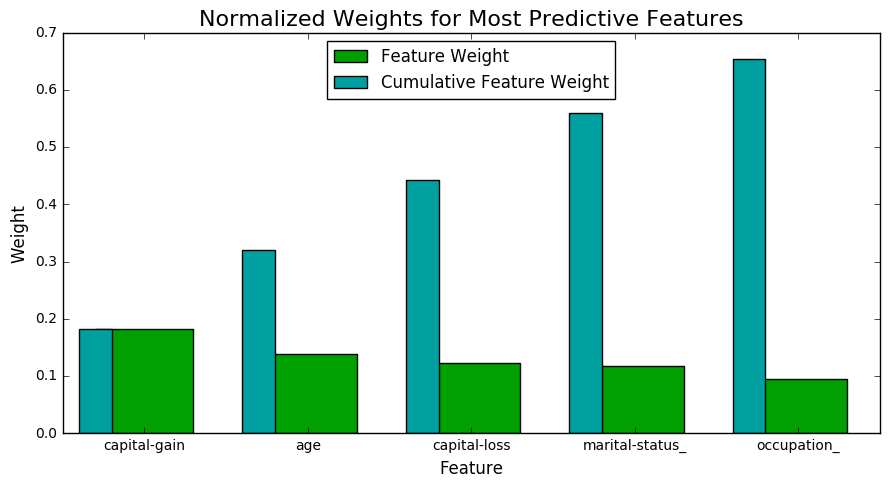

In [13]:
importances = best_clf.feature_importances_
# I tweaked the definition of vs.feature_plot a bit. I got rid of the unused
# y_train argument, and made it more flexible so I could also create the
# second plot below.
vs.feature_plot(importances, X_train.columns.values)

# Unfortunately, the above plot accounts for the effects of every single level of 
# each categorical variable separately. If we want to view each of the categorial
# variables holistically, the following code will aggregate their gains.
column_categories = [v.split()[0] for v in X_train.columns.values]
categories = list(set(column_categories))
category_importances = np.array([0.0] * len(categories))
for i, w in enumerate(importances):
    category_index = categories.index(column_categories[i])
    category_importances[category_index] += w

# Plot the aggregated importances
vs.feature_plot(category_importances, np.array(categories))

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

As it turns out, my intuition was relatively close to the mark. I successfully predicted four out of the top five features (capital gain, capital loss, age, and either occupation or education, depending on whether you aggregate the levels of the categorical variables). I also got the order roughly right, with the exception of flipping age and capital loss. However, I completely underestimated the importance of marital status.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions, cutoff = predict_adjusted(clf, X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8687
F-score on testing data: 0.7684

Final Model trained on reduced data
------
Accuracy on testing data: 0.8574
F-score on testing data: 0.7378


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

The final model performs quite a bit better than the model fit to the reduced set of features -- in fact, the model trained on the reduced data performs (slightly) worse than the unoptimized model.

It's hard to say in the abstract whether I would consider using the reduced data as my training set. The answer would depend on whether there was some larger superset of data available on which to train the model and CharityML's willingness to wait for a better-performing model, among other things.

However, the biggest problem with the idea of using the reduced set to fit a model is that we are selecting features on the basis of the output from the full model. We were only able to identify the most important features by fitting a model with all of the features. If we need to create a great-performing model as an intermediate step on our way to fitting a mediocre-performing model, why not just stop at the great-performing model?

Of course, in the real world, we are often faced with hundreds or thousands of potential features for any particular supervised learning model, and we have to choose which set of variables to gather or scrape in the first place -- this is a heuristic, human-driven form of feature selection.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.